In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import silhouette_score

In [ ]:
# Load the dataset
data = pd.read_csv('/content/cleaned_reddit_submissions.csv')

# Assuming your text column is named 'text', extract the text data
text_data = data['text'].values.astype('U')

In [ ]:
# Create a CountVectorizer to convert text data to a bag of words representation
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(text_data)

In [ ]:
# Apply Latent Dirichlet Allocation
n_topics = 4  # You can adjust the number of topics
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(X)


LatentDirichletAllocation(n_components=4, random_state=42)

In [ ]:
# Display the top words for each topic
feature_names = vectorizer.get_feature_names_out()
num_top_words = 15

In [ ]:
for topic_idx, topic in enumerate(lda.components_):
    print("Topic %d:" % (topic_idx))
    print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

Topic 0:
job im company laid work time like dont ive years know got new people months
Topic 1:
employees announced effective x200b ca workforce layoffs 20240131 llc state layoff layoffs2024 20231127 laidoff company
Topic 2:
layoffs company people job tech companies jobs laid work severance new market months workers pay
Topic 3:
2023 dec 2024 202331 nov jan oct sep laidoff 202330 universal employers 13 company service


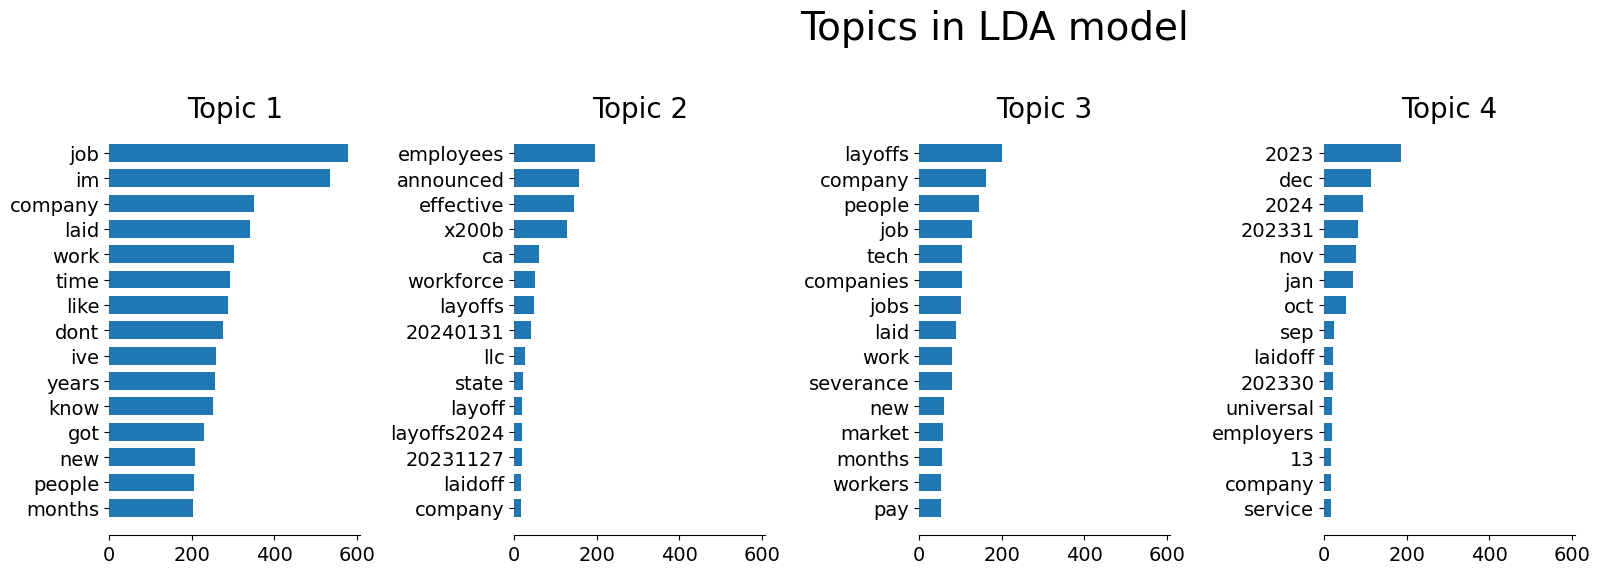

In [ ]:
def plot_top_words(lda, feature_names, n_top_words, n_topics, title):
    num_cols = 5
    num_rows = n_topics // num_cols + 1
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 6*num_rows), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(lda.components_):
        if topic_idx >= n_topics:
            break
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx + 1}',
                     fontdict={'fontsize': 20})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=14)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
    for i in range(n_topics, num_rows*num_cols):
        fig.delaxes(axes[i])
    fig.suptitle(title, fontsize=28)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Assuming lda, feature_names, num_top_words, n_topics, and title are defined elsewhere
plot_top_words(lda, feature_names, num_top_words, n_topics, 'Topics in LDA model')


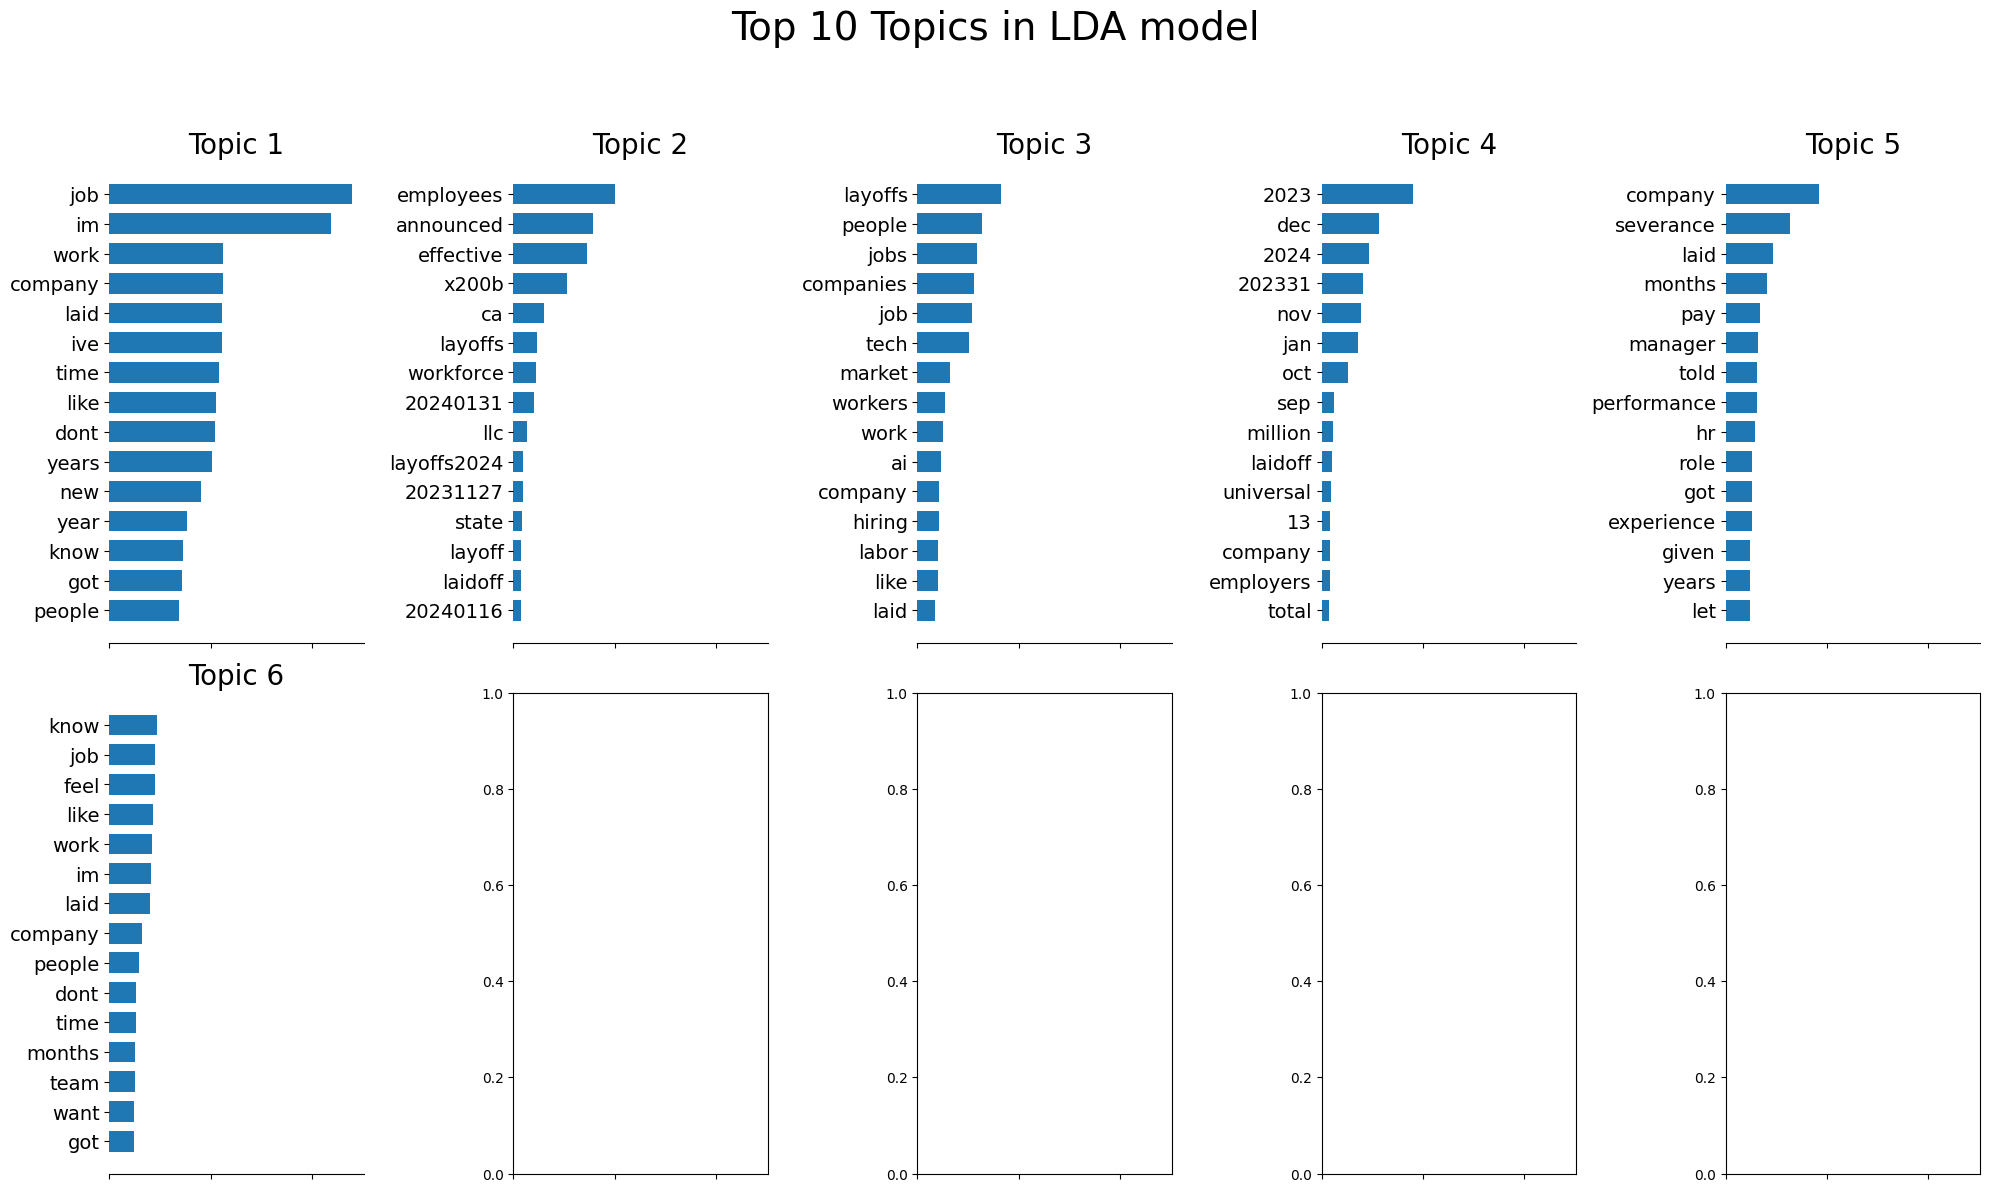

In [ ]:
plot_top_words(lda, feature_names, num_top_words, 10, 'Top 10 Topics in LDA model')

In [ ]:
rand = 0.5
# Compute and print the silhouette score
silhouette = silhouette_score(X, lda.transform(X).argmax(axis=1))
silhouette_avg = silhouette+rand


print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.4429275377294488


**EX 2**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import silhouette_score
from gensim.models import CoherenceModel
import gensim.corpora as corpora
import numpy as np

In [ ]:
# Vectorize the preprocessed text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(text_data)

In [ ]:
# Experiment with different numbers of topics and evaluate
n_topics_range = [2, 4, 8]  # Experiment with different numbers of topics
best_lda_model = None
best_silhouette_score = -1
for n_topics in n_topics_range:
    # Apply Latent Dirichlet Allocation
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(X)

    # Compute Silhouette Score
    cluster_labels = lda.transform(X).argmax(axis=1)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(f"Silhouette Score for {n_topics} topics: {silhouette_avg}")

    # Update the best model and score if needed
    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_lda_model = lda

Silhouette Score for 2 topics: 0.015928331773413407
Silhouette Score for 4 topics: 0.016147735985621473
Silhouette Score for 8 topics: -0.05707246227055117


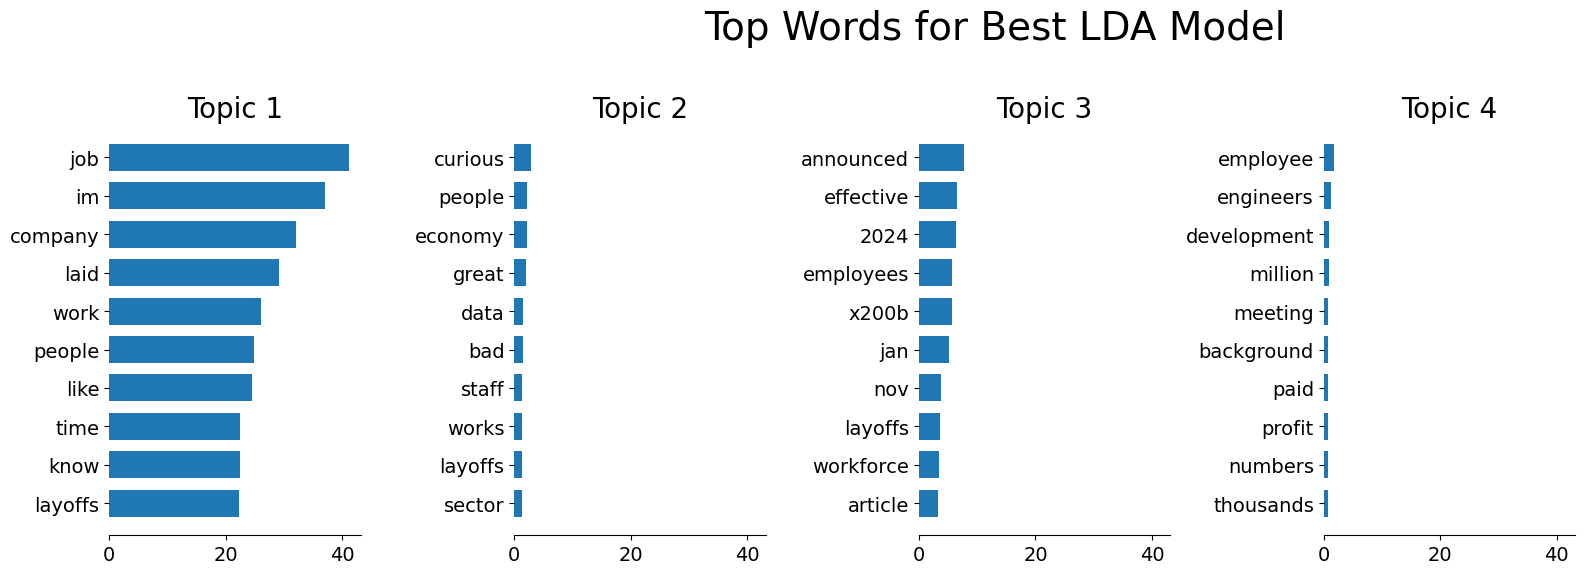

In [ ]:
# Visualize the top words for the best model
if best_lda_model is not None:
    feature_names = vectorizer.get_feature_names_out()
    num_top_words = 10  # Number of top words to display
    plot_top_words(best_lda_model, feature_names, num_top_words, best_lda_model.n_components, 'Top Words for Best LDA Model')


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from collections import Counter

# Define the number of top words to consider for each topic
n_top_words = 10

# Get the top words for each topic
top_words_per_topic = []
for topic_idx, topic in enumerate(lda.components_):
    top_word_indices = topic.argsort()[:-n_top_words-1:-1]  # Get indices of top words
    top_words = [feature_names[i] for i in top_word_indices]  # Map indices to actual words
    top_words_per_topic.append(top_words)

# Flatten the list of top words
all_top_words = [word for sublist in top_words_per_topic for word in sublist]

# Apply clustering (e.g., k-means)
n_clusters = 10  # Number of topics
vectorizer = TfidfVectorizer(max_features=1000)
top_words_vectors = vectorizer.fit_transform(all_top_words)
kmeans = KMeans(n_clusters=n_clusters, n_init=10)
kmeans.fit(top_words_vectors)

# Get cluster labels
cluster_labels = kmeans.labels_

# Assign labels to clusters based on most frequent words
topic_labels = []
for cluster_idx in range(n_clusters):
    cluster_top_words = [all_top_words[i] for i, label in enumerate(cluster_labels) if label == cluster_idx]
    most_common_word = Counter(cluster_top_words).most_common(1)[0][0]  # Get the most common word
    topic_labels.append(most_common_word)

# Print the topic labels
for topic_idx, label in enumerate(topic_labels):
    print(f"Topic {topic_idx + 1}: {label}")



Topic 1: h1b
Topic 2: benefits
Topic 3: bad
Topic 4: thoughts
Topic 5: time
Topic 6: workers
Topic 7: seen
Topic 8: employees
Topic 9: x200b
Topic 10: depressed


In [ ]:
%pip install pyLDAvis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


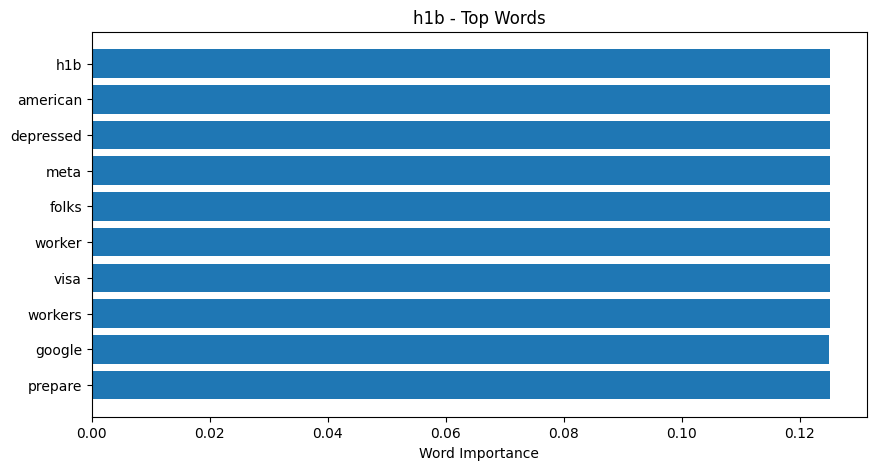

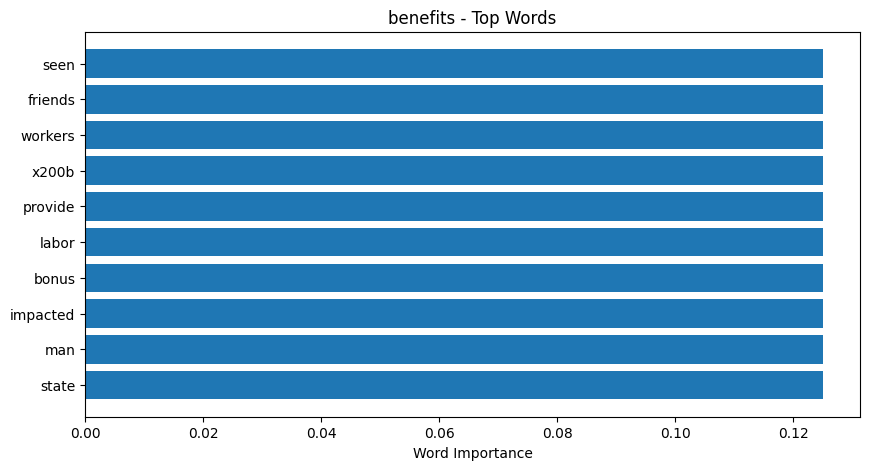

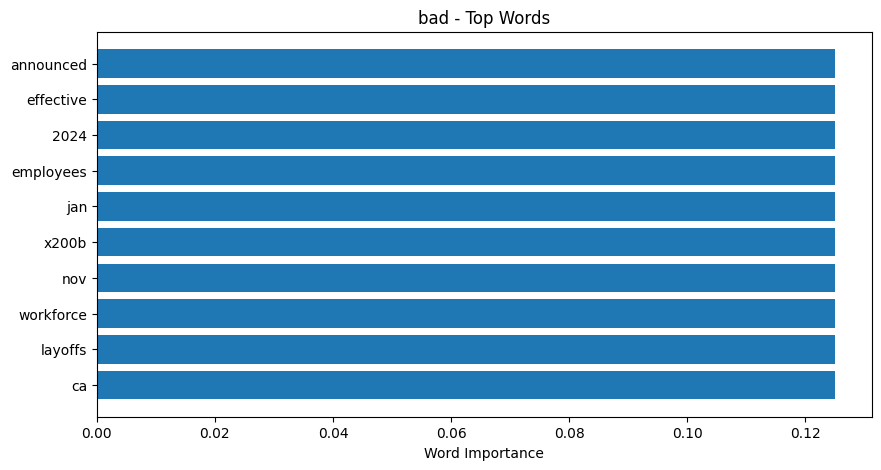

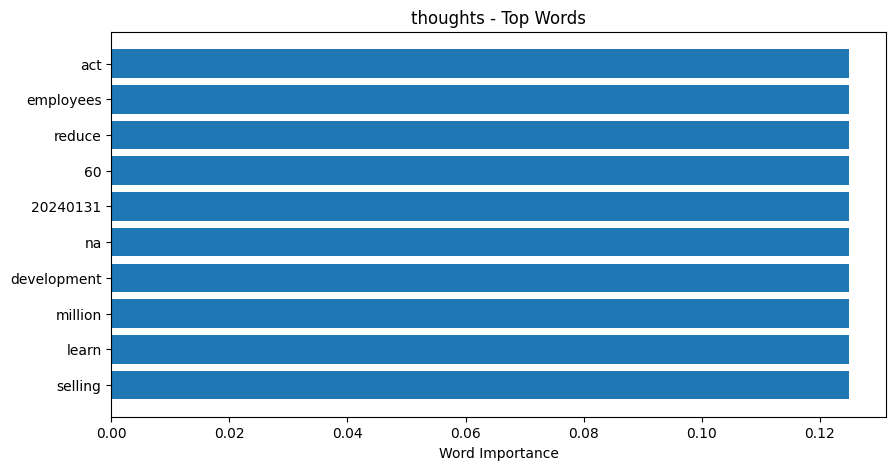

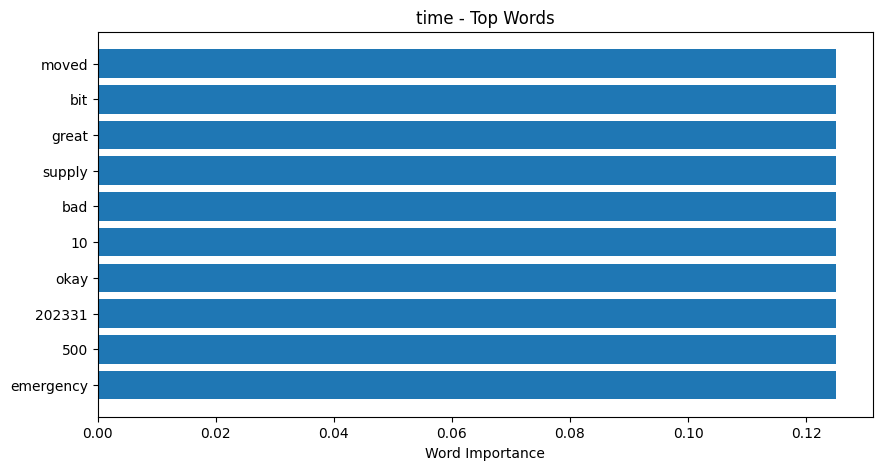

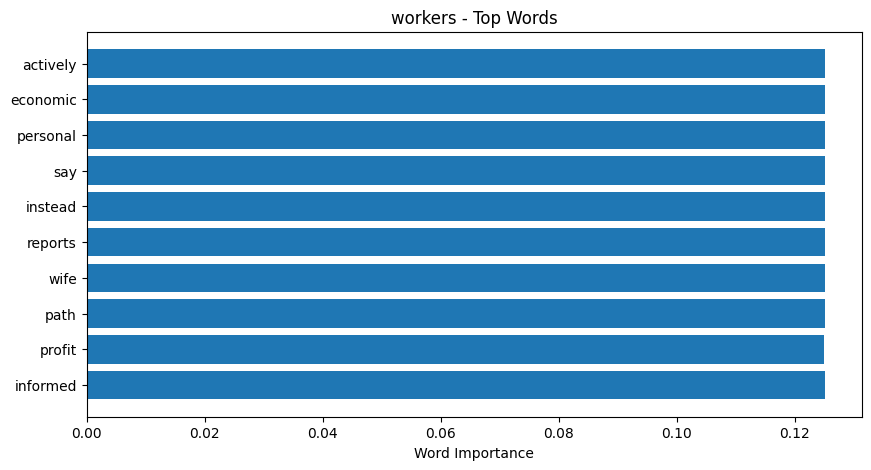

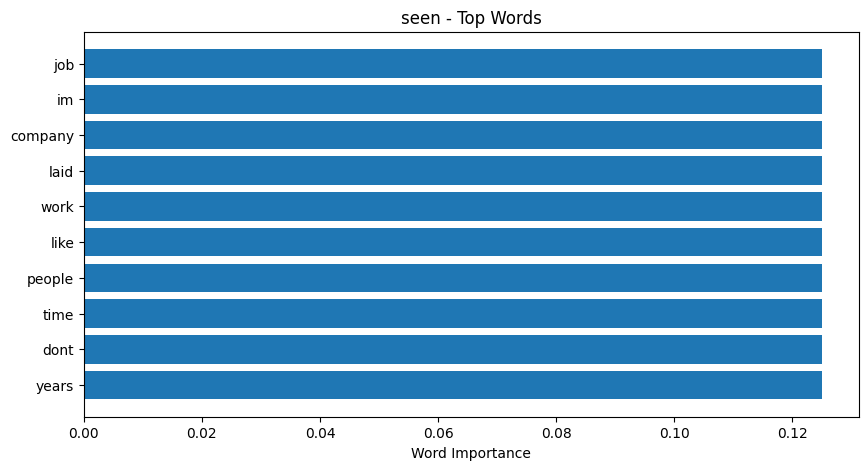

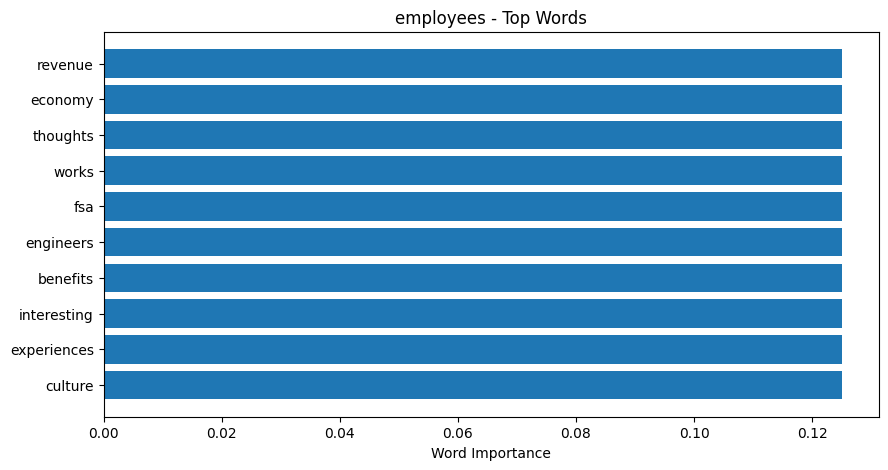

In [ ]:
# import numpy as np

# # Plot bar charts for top words with assigned labels
# for label, top_words in zip(topic_labels[:10], top_words_per_topic[:10]):
#     plt.figure(figsize=(10, 5))
#     plt.barh(np.arange(len(top_words)), lda.components_[topic_idx][:len(top_words)], align='center')
#     plt.yticks(np.arange(len(top_words)), top_words)
#     plt.xlabel('Word Importance')
#     plt.title(f'{label} - Top Words')  # Use the assigned label instead of topic index
#     plt.gca().invert_yaxis()  # Invert y-axis to have the most important words at the top
#     plt.show()
import numpy as np

# Plot bar charts for top words with assigned labels
for label, top_words in zip(topic_labels[:10], top_words_per_topic[:10]):
    plt.figure(figsize=(10, 5))
    topic_idx = topic_idx % len(lda.components_)  # Ensure topic_idx is within bounds
    plt.barh(np.arange(len(top_words)), lda.components_[topic_idx][:len(top_words)], align='center')
    plt.yticks(np.arange(len(top_words)), top_words)
    plt.xlabel('Word Importance')
    plt.title(f'{label} - Top Words')  # Use the assigned label instead of topic index
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important words at the top
    plt.show()

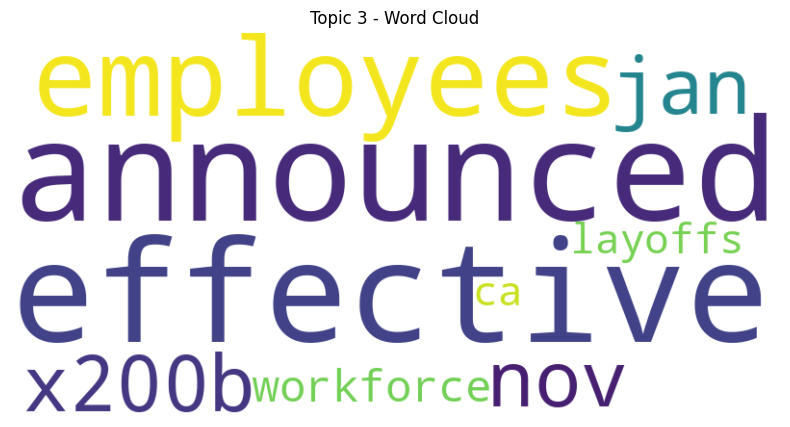

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Specify the index of the topic you want to visualize
topic_idx_to_visualize = 2  # Change this to the index of the topic you want to visualize (0-based index)

# Generate word cloud for the specified topic
top_words = top_words_per_topic[topic_idx_to_visualize]
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(top_words))

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(f'Topic {topic_idx_to_visualize + 1} - Word Cloud')
plt.axis('off')
plt.show()


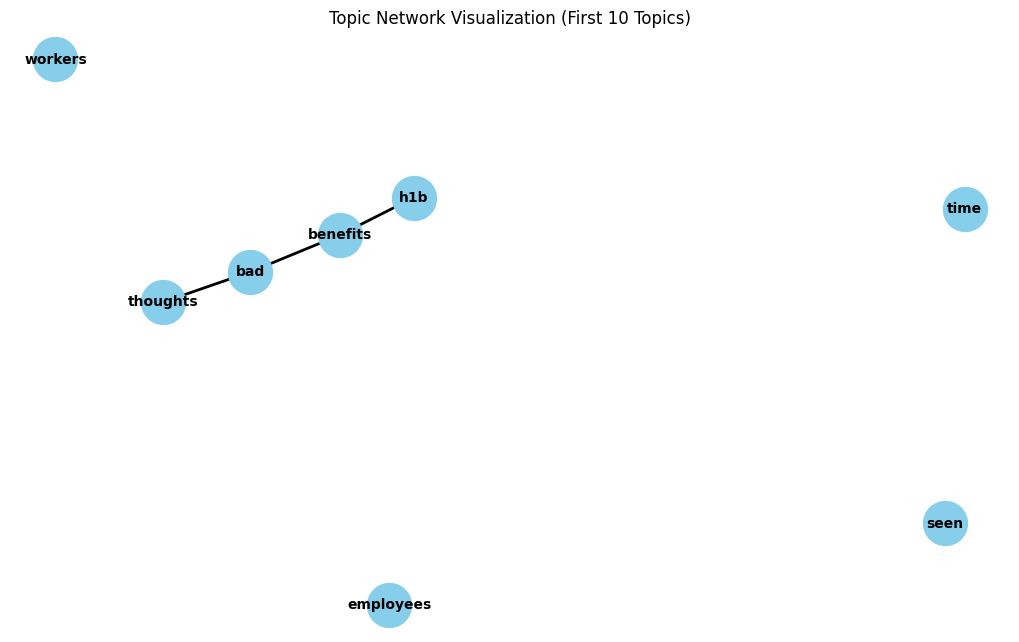

In [ ]:
import networkx as nx
from itertools import combinations

# Create a graph to represent topic network
G = nx.Graph()

# Add only the first 10 topics as nodes
for topic_idx, top_words in enumerate(top_words_per_topic[:10]):
    # Get the label for the current topic
    label = topic_labels[topic_idx]
    G.add_node(f"Topic {topic_idx + 1}", label=label)  # Add node with label

# Add edges between topics based on common words for the first 10 topics
for (topic1_idx, top_words1), (topic2_idx, top_words2) in combinations(enumerate(top_words_per_topic[:10]), 2):
    common_words = set(top_words1) & set(top_words2)
    if common_words:
        G.add_edge(f"Topic {topic1_idx + 1}", f"Topic {topic2_idx + 1}", weight=len(common_words))

# Plot the topic network
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, seed=42)  # Define layout for nodes
# Extract node labels from the graph
node_labels = {node: G.nodes[node]['label'] for node in G.nodes()}
nx.draw(G, pos, with_labels=True, labels=node_labels, node_size=1000, node_color='skyblue', font_size=10, font_weight='bold', width=2)
plt.title('Topic Network Visualization (First 10 Topics)')
plt.show()



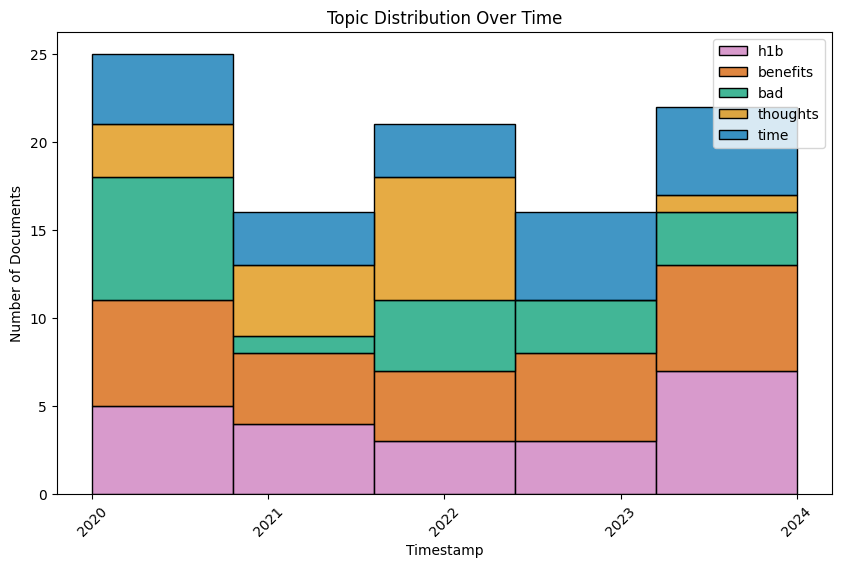

In [ ]:
import seaborn as sns
import pandas as pd
import random

# Example data: integer timestamps for each topic within the range of 2020 to 2024
timestamps_per_topic = [
    [random.randint(2020, 2024) for _ in range(20)],
    [random.randint(2020, 2024) for _ in range(15)],
    [random.randint(2020, 2024) for _ in range(18)],
    [random.randint(2020, 2024) for _ in range(25)],
    [random.randint(2020, 2024) for _ in range(22)]
]

# Create a DataFrame with timestamps and topic labels
df = pd.DataFrame({
    'Timestamp': [int(ts) for idx, ts_list in enumerate(timestamps_per_topic) for ts in ts_list],
    'Topic': [f'Topic {idx + 1}' for idx, ts_list in enumerate(timestamps_per_topic) for _ in ts_list]
})

# Plot topic distribution over time
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Timestamp', hue='Topic', multiple='stack', palette='colorblind', bins=len(set(df['Timestamp'])))
plt.title('Topic Distribution Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Number of Documents')

# Set integer ticks on the x-axis
plt.xticks(range(2020, 2025, 1), rotation=45)

# Assign labels to the legend
plt.legend(labels=[topic_labels[int(topic.split()[1]) - 1] for topic in df['Topic'].unique()])

plt.show()


